## Import ##

In [37]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model_profiler import model_profiler
import pathlib
from pathlib import Path
import cv2 as cv
import json
import pandas as pd
import nvidia_smi
from numba import cuda

batch_size = 50
epoch_size = 3000
test_len = 8

In [38]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


# p = pathlib.Path('../../openCV_python/data/out/resized_frames/resized')
# txt_files = list(p.glob('*.txt'))
# img_files = [item.parent.resolve() / item.stem for item in txt_files]
# txt_files[0].stem
# image = txt_files[0].parent.resolve() / txt_files[0].stem

# img_count = len(txt_files)
# img_shape = cv.imread(str(image)).shape

# txt_shape = get_txt_data(txt_files[0]).shape

# input_shape = (img_count, *img_shape)
# output_shape = (img_count, *txt_shape)
input_data: np.ndarray = np.load('data/train_input.npy')
output_data: np.ndarray = np.load('data/train_output.npy')
input_shape = input_data.shape[1:]
output_shape = output_data.shape[1:]
# data = []

# for i in range(len(img_files)):
#     input_data[i] = cv.imread(str(img_files[i]))
#     output_data[i] = get_txt_data(txt_files[i])

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]
    print('Train shape: {}'.format(train_images.shape))
    print('Test shape: {}'.format(test_images.shape))

    return (train_images, train_labels), (test_images, test_labels)


input shape
(29, 20)

output shape
(8,)


In [39]:
(train_images, train_labels), (test_images, test_labels) = load_data()
input_shape = train_images.shape[1:3]


Train shape: (5404, 29, 20)
Test shape: (771, 29, 20)


In [40]:
activation_fun = 'gelu'
print(np.prod(input_shape))

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(input_shape))
model.add(normalization)
model.add(tf.keras.layers.Conv1D(32, 3, activation=activation_fun))
model.add(tf.keras.layers.Conv1D(32, 3, activation=activation_fun))
model.add(tf.keras.layers.MaxPooling1D(2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024 * 120, activation_fun))
# model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(1024, activation_fun))
model.add(tf.keras.layers.Dense(8))

model.summary()


580


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 29, 20)           3         
 ion)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 27, 32)            1952      
                                                                 
 conv1d_11 (Conv1D)          (None, 25, 32)            3104      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 384)               0         
                                                                 
 dense_10 (Dense)            (None, 122880)           

In [41]:
# profile = model_profiler(model, batch_size)

# print(profile)


In [42]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/3000
55/55 [==============================] - 2s 34ms/step - loss: 158.8749 - val_loss: 102.1942
Epoch 2/3000
55/55 [==============================] - 2s 32ms/step - loss: 92.2337 - val_loss: 146.0277
Epoch 3/3000
55/55 [==============================] - 2s 32ms/step - loss: 82.9538 - val_loss: 76.9187
Epoch 4/3000
55/55 [==============================] - 2s 32ms/step - loss: 66.6021 - val_loss: 66.3920
Epoch 5/3000
55/55 [==============================] - 2s 32ms/step - loss: 60.3189 - val_loss: 60.0926
Epoch 6/3000
55/55 [==============================] - 2s 32ms/step - loss: 54.5770 - val_loss: 61.7322
Epoch 7/3000
55/55 [==============================] - 2s 31ms/step - loss: 53.0181 - val_loss: 54.2667
Epoch 8/3000
55/55 [==============================] - 2s 31ms/step - loss: 47.5472 - val_loss: 54.6726
Epoch 9/3000
55/55 [==============================] - 2s 31ms/step - loss: 44.6838 - val_loss: 49.4141
Epoch 10/3000
55/55 [==============================] - 2s 31ms/step - 

In [43]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [5.5699944496154785, 5.469057083129883, 6.362249851226807, 5.255176067352295, 5.4104084968566895, 5.034018516540527, 5.503445625305176, 5.522520065307617, 4.981854438781738, 5.519603252410889, 5.134392261505127, 5.267996311187744, 5.357560157775879, 5.339993953704834, 5.245916843414307, 5.2104620933532715, 5.136332035064697, 4.923118591308594, 5.415957927703857, 5.405516147613525, 5.361175060272217, 5.442144870758057, 5.236506462097168, 5.81865119934082, 5.355385780334473, 5.439760208129883, 5.603862762451172, 5.858689785003662, 4.991724491119385, 5.46389102935791, 5.107629299163818, 5.2670207023620605, 6.7701616287231445, 5.011580467224121, 5.359111785888672, 5.317408084869385, 5.89078426361084, 5.415897369384766, 5.510366439819336, 5.29884672164917, 6.373866558074951, 6.100428581237793, 5.502155780792236, 5.457208156585693, 5.305866241455078, 5.727027416229248, 5.3847527503967285, 4.762129306793213, 5.1321024894714355, 4.972787380218506, 5.219874858856201, 5.619805812835693,

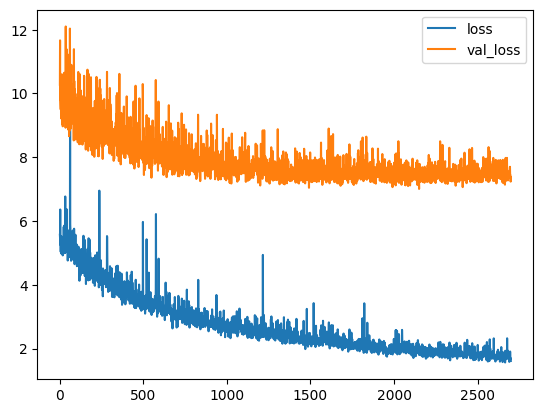

In [44]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [45]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [46]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
